In [41]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from init_mnist import MNIST
from ipywidgets import interact

from cw_attack import CW_Attack
from train_cnn_mnist import CNN, CNNTrain
import torchattacks

from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [47]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

def torch_img_show(image, label):
  npimg = image.cpu().numpy()
  fig = plt.figure(figsize = (5, 15))
  plt.imshow(image, cmap='gray')
  plt.title(label)
  plt.show()

In [20]:
trainer = CNNTrain()
trainer.model_train()

model = trainer.model
#model.eval()
mnist = trainer.mnist

CNN model loaded


True Label: 5, Predcited: 5
CW(model_name=CNN, device=cpu, attack_mode=default, targeted=False, normalization_used=False, c=1, kappa=0, steps=1000, lr=0.01)


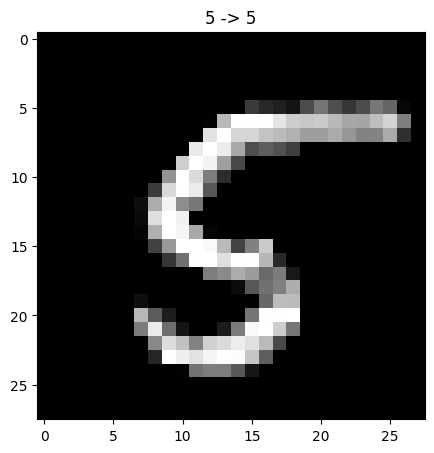

In [21]:
# Prepare data
images, labels = next(iter(mnist.test_loader))

true_y = labels.item()
pred_y = torch.argmax(model(images)).item()
print(f"True Label: {true_y}, Predcited: {pred_y}")

# CW Attack
attack = torchattacks.CW(model, c=1, steps=1000, lr=0.01)
#attack.set_mode_targeted_random(10)
#attack.set_mode_targeted_least_likely(3)
print(attack)
adv_images = attack(images, labels)

# Evaluate
adv_pred = model(adv_images)
adv_pred_y = torch.argmax(adv_pred).item()

title = f"{true_y} -> {adv_pred_y}"
torch_img_show(adv_images[0][0], title)

In [22]:
if os.path.exists('data') != True:
  os.mkdir('data')

if os.path.exists('data/test') != True:
  os.mkdir('data/test')
for i in range (0, 10):
  if os.path.exists(f'data/test/{i}') != True:
    os.mkdir(f'data/test/{i}')

if os.path.exists('data/train') != True:
  os.mkdir('data/train')
for i in range (0, 10):
  if os.path.exists(f'data/train/{i}') != True:
    os.mkdir(f'data/train/{i}')

In [23]:
# for idx in range(0, len(mnist.data_test)):
#   image, label = mnist.data_test[idx]

#   images = image.unsqueeze(0)
#   labels = torch.tensor(label, dtype=torch.int8)
#   adv_images = attack(images, labels)

#   url = f"data/test/{labels.item()}/{idx}.png"
#   if os.path.exists(url) != True:
#     save_image(adv_images, url)



In [85]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), # regularazation : range of 0~1
])

adv_data = ImageFolder(root='data/test', transform=transform_test)
adv_loader = DataLoader(dataset=adv_data, batch_size=1, shuffle=False)

def model_predict(image, label):
    with torch.no_grad():
        image_torch = image.data.view(1, 1, 28, 28).float().to(device)
        predict = model(image_torch)
        print(f"Label: {label} Predict: {torch.argmax(predict)}")
        return predict

def model_evaluate(test_loader):
    test_loss = 0
    correct_cnt = 0
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        model.eval()
        for image, label in test_loader:
            predict_logit = model(image)
            test_loss += criterion(predict_logit, label).item()
            predict = torch.argmax(predict_logit)
            correct_cnt += predict.eq(label.view_as(predict)).sum().item()
        print(f"Loss: {test_loss:.2f}, Correct: {(correct_cnt/len(test_loader))*100:.2f}% = {correct_cnt}/{len(test_loader)}")
        return test_loss, correct_cnt

images, labels =adv_data[1]
pred = model_predict(images[0], labels)
model_evaluate(adv_loader)
print("")

Label: 0 Predict: 9
Loss: 7083.64, Correct: 36.85% = 3685/10000



Using an autoencoder to distinguish adversarial examples

In [87]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28*28),
            torch.nn.Sigmoid(),
        )
    
    def forward(self, x):
       encoded = self.encoder(x)
       decoded = self.decoder(encoded)
       return encoded, decoded


autoencoder = AutoEncoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
loss = torch.nn.MSELoss()

# trains model
for epoch in range(15):
    avg_cost = 0

    for X, Y in mnist.train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = loss(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print(f'[Epoch: {(epoch+1):>4}] cost = {avg_cost:>.9}')
autoencoder.train()


  

# def cal_mnist_diff(model, data, range, avg=0, std=0):
#   decoded = model(data)
#   o_diff = (np.abs(data.reshape(-1, 28, 28) - decoded)).reshape(-1, 28*28)
#   o_diff_sum = np.sum(o_diff, axis=1)
#   print(o_diff_sum)

#   # for training (calculate avg and std)
#   if(avg == 0 and std == 0):
#     avg = np.average(o_diff_sum)
#     std = np.std(o_diff_sum)
#     print(f"[Avg]: {avg:.2f} [Std]: {std:.2f} [Range]: {avg-std*range:.2f} ~ {avg+std*range:.2f}")

#   # Search indices that is out of range
#   search_result = np.where((o_diff_sum > avg+std*range) | (o_diff_sum  < avg-std*range))

#   n_total = len(o_diff_sum)
#   n_out_of_bound = len(search_result[0])

#   print(f"[Out-of-bound Ratio]]: {(n_out_of_bound/n_total)*100:.2f}% ({n_out_of_bound}/{n_total})")
#   return o_diff_sum, avg, std

# diff, avg, std = cal_mnist_diff(normal_ae_model, train_x, 5)
# test_diff = cal_mnist_diff(normal_ae_model, test_x, 5, avg, std)

NameError: name 'normal_ae_model' is not defined

FGSM(model_name=CNN, device=cpu, attack_mode=targeted(random), targeted=True, normalization_used=False, eps=0.25)


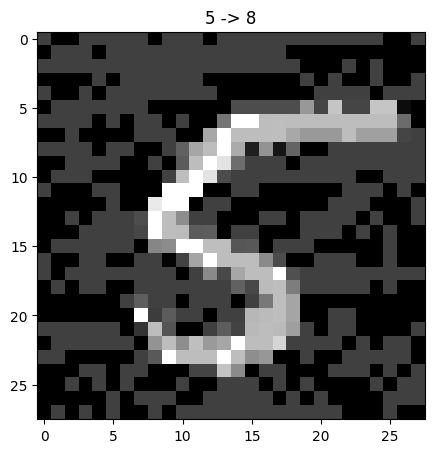

In [36]:
# FGSM Attack
attack = torchattacks.FGSM(model, 0.25)
attack.set_mode_targeted_random(10)
#attack.set_mode_targeted_least_likely(3)
print(attack)
adv_images = attack(images, labels)

# Evaluate
adv_pred = model(adv_images)
adv_pred_y = torch.argmax(adv_pred).item()

title = f"{true_y} -> {adv_pred_y}"
torch_img_show(adv_images[0][0], title)

PGD(model_name=CNN, device=cpu, attack_mode=targeted(random), targeted=True, normalization_used=False, eps=0.03137254901960784, alpha=0.008888888888888889, steps=10, random_start=True)


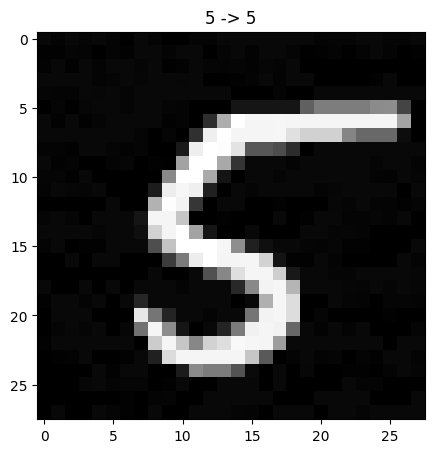

In [26]:
# PGD Attack
attack = torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
attack.set_mode_targeted_random(10)
#attack.set_mode_targeted_least_likely(3)
print(attack)
adv_images = attack(images, labels)

# Evaluate
adv_pred = model(adv_images)
adv_pred_y = torch.argmax(adv_pred).item()

title = f"{true_y} -> {adv_pred_y}"
torch_img_show(adv_images[0][0], title)